# DATA  CLEANING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Loading Companies and Rounds data

companies = pd.read_csv('Companies.txt', sep = '\t', encoding = 'ISO-8859-1')
rounds2 = pd.read_csv('rounds2.csv', encoding = 'ISO-8859-1')

# converting the column names to lower case assuming the data is case insensitive
# After ooking at both the files we find no common entries if we take case sensitivity into consideration
# hence making both the entries into lower case
companies['permalink']=companies['permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()

# We see that there are many companies that have not been decoded properly due to different encodings used
# Hence encoding to utf-8 and decoding back the columns of permalink to remove non-ASCII characters

companies['permalink'] = companies.permalink.str.encode('utf-8').str.decode('ascii', 'ignore')
rounds2['company_permalink']= rounds2.company_permalink.str.encode('utf-8').str.decode('ascii', 'ignore')

#To compute the number of unique elements in each columns of the data frame

# Here company_permalink is the unique id for a company in rounds2 dataframe
unique_comp_rounds2 = rounds2['company_permalink'].nunique()
print(f'The number of unique companies present in rounds2 = {unique_comp_rounds2} \n')

# permalink is the unique id for a company in the companies dataframe
unique_comp_companies = companies['permalink'].nunique()
print(f'The number of unique companies present in companies = {unique_comp_companies} \n')



The number of unique companies present in rounds2 = 66368 

The number of unique companies present in companies = 66368 



In [2]:
# To check the columns in which count of the values = unique values. permalink has the count equal to unique
# Hence it can be the unique key for each company
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
permalink        66368 non-null object
name             66367 non-null object
homepage_url     61310 non-null object
category_list    63220 non-null object
status           66368 non-null object
country_code     59410 non-null object
state_code       57821 non-null object
region           58338 non-null object
city             58340 non-null object
founded_at       51147 non-null object
dtypes: object(10)
memory usage: 5.1+ MB


In [3]:
# renaming the coulmnn in rounds2 to correspond to companies for easier manipulation
rounds2.rename(columns = {'company_permalink':'permalink'}, inplace=True)

# Performing outer merge to get all the data, the _merge column has 3 entries which are right only
# So there are companies present in rounds2 not present in companies

outer_merged_df = pd.merge(companies,
                           rounds2,
                           how='outer', 
                           on='permalink',
                           indicator=True)

# Here column '_merge' will have 'right_only' values if the entry is only present in the right dataframe i.e. rounds2
print(sum(outer_merged_df['_merge']=='right_only'))


3


In [4]:

# Performing left merge to get the master Dataframe
# Left merge allows us to get the data for all the sectors across various countries
# We can use this to find the best sectors and later on filter out by countries

master_frame = pd.merge(rounds2, 
                        companies,
                        how='left', 
                        on='permalink')


print(master_frame.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 15 columns):
permalink                  114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
name                       114945 non-null object
homepage_url               108812 non-null object
category_list              111538 non-null object
status                     114946 non-null object
country_code               106270 non-null object
state_code                 104002 non-null object
region                     104781 non-null object
city                       104784 non-null object
founded_at                 94425 non-null object
dtypes: float64(1), object(14)
memory usage: 14.0+ MB
None


In [5]:
master_frame.isnull().sum()
# We see that most of the values in funding_round_code is missing, removing this column.

master_frame = master_frame.drop('funding_round_code',1)

In [6]:
# The raised amounts for various funding types have 0 values and the standard deviation is also very high
# Hence removing these rows with NULL values since they constitute to only about 14% of data
master_frame = master_frame[master_frame.raised_amount_usd.notnull()]


In [7]:
# The cleaned up dataframe is used to answer question 5, Table 1.1
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94959 entries, 0 to 114948
Data columns (total 14 columns):
permalink                  94959 non-null object
funding_round_permalink    94959 non-null object
funding_round_type         94959 non-null object
funded_at                  94959 non-null object
raised_amount_usd          94959 non-null float64
name                       94956 non-null object
homepage_url               90625 non-null object
category_list              93914 non-null object
status                     94957 non-null object
country_code               89107 non-null object
state_code                 87354 non-null object
region                     87910 non-null object
city                       87913 non-null object
founded_at                 78991 non-null object
dtypes: float64(1), object(13)
memory usage: 10.9+ MB


# Funding Type Analysis

In [8]:
funding_types = master_frame.groupby('funding_round_type')

In [9]:
# Finding the number of investments under each type of funds
# Venture and Seed clearly have a lot more number of investments than the other types
funding_types['raised_amount_usd'].count().sort_values(ascending  = False)

funding_round_type
venture                  50228
seed                     23603
debt_financing            6682
angel                     4860
grant                     2124
private_equity            1936
undisclosed               1582
convertible_note          1447
equity_crowdfunding       1228
post_ipo_equity            628
product_crowdfunding       386
post_ipo_debt              152
non_equity_assistance       73
secondary_market            30
Name: raised_amount_usd, dtype: int64

In [10]:
# Finding the total amount of investments for different types of funds
# Here Venture, Private equity and debt_financing have more amount invested in them
funding_types['raised_amount_usd'].sum().sort_values(ascending  = False)

funding_round_type
venture                  5.901262e+11
private_equity           1.419254e+11
debt_financing           1.138848e+11
post_ipo_equity          5.161061e+10
undisclosed              3.044143e+10
post_ipo_debt            2.564309e+10
seed                     1.698986e+10
grant                    9.134424e+09
angel                    4.659255e+09
secondary_market         2.389489e+09
convertible_note         2.103126e+09
equity_crowdfunding      6.611162e+08
product_crowdfunding     5.261686e+08
non_equity_assistance    3.001782e+07
Name: raised_amount_usd, dtype: float64

In [11]:
# Since these funds vary over a wide range of values and many values are concentrated across a certain intevral
# for each type of funds. Hence if we look at the Medain values
# Only venture and post_ipo_equity have the values betweeen 5 and 15 Million USD
# From the above 3 observations its clearly evident venture is the best fund type to imvest in for our requirement.

funding_types['raised_amount_usd'].median().sort_values(ascending = False)

funding_round_type
secondary_market         32600000.0
private_equity           20000000.0
post_ipo_debt            19950000.0
post_ipo_equity          12262852.5
venture                   5000000.0
debt_financing            1100000.0
undisclosed               1018680.0
angel                      400000.0
seed                       275000.0
convertible_note           272000.0
grant                      201684.0
product_crowdfunding       183915.0
equity_crowdfunding        100000.0
non_equity_assistance       60000.0
Name: raised_amount_usd, dtype: float64

In [12]:
# Finding the mean of investment amount for different types of funds
# Even here we see that venture has an average of about 11 Million USD.
funding_types['raised_amount_usd'].mean().sort_values(ascending = False)

funding_round_type
post_ipo_debt            1.687046e+08
post_ipo_equity          8.218249e+07
secondary_market         7.964963e+07
private_equity           7.330859e+07
undisclosed              1.924237e+07
debt_financing           1.704353e+07
venture                  1.174895e+07
grant                    4.300576e+06
convertible_note         1.453439e+06
product_crowdfunding     1.363131e+06
angel                    9.586945e+05
seed                     7.198180e+05
equity_crowdfunding      5.383682e+05
non_equity_assistance    4.112031e+05
Name: raised_amount_usd, dtype: float64

In [13]:
# Creating an updated dataframe to filter out the investments the company is not interested in
# The updated dataframe only contains Venture type of investments
master_frame = master_frame[master_frame.funding_round_type.isin(['venture'])]

# Country Analysis

In [14]:
# Now since we are narrowing down to the countries removing any NULL values in the Country code column
master_frame = master_frame[master_frame.country_code.notnull()]

In [15]:
master_frame.isnull().sum()

permalink                     0
funding_round_permalink       0
funding_round_type            0
funded_at                     0
raised_amount_usd             0
name                          0
homepage_url               2175
category_list               302
status                        0
country_code                  0
state_code                  744
region                      596
city                        596
founded_at                 8551
dtype: int64

In [16]:
temp_frame_top9 = master_frame.groupby('country_code')

# Get the top 9 countries as a list
# Here we have not yet taken the english language into consideration
list_top9_countries = list(temp_frame_top9['raised_amount_usd'].sum().nlargest(n=9).keys())


In [18]:
# List of top 6 countries based on the number of investments in Venture type
list_top9_countries_byCount = list(temp_frame_top9['raised_amount_usd'].sum().nlargest(n=9).keys())
list_top9_countries_byCount

['USA', 'CHN', 'GBR', 'IND', 'CAN', 'FRA', 'ISR', 'DEU', 'JPN']

In [19]:
# top9 has the top 9 countries on funds raised for the Venture type.
top9 = master_frame[master_frame.country_code.isin(list_top9_countries)]

In [20]:
# Off the top9 countries, the top 3 english speaking countries are USA, GBR and IND
# Above data collected from Wikipedia
# Hence Creating a dataframe top3 to work with henceforth

top3 = top9[top9.country_code.isin(['USA', 'GBR', 'IND'])]

In [21]:
# Removing entries which do not have any categories since the next step involves dealing with different sectors
# Very few entries do not have category, so removing them as it wont be affecting the results much
top3 = top3[top3.category_list.notnull()]

In [22]:
top3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38803 entries, 0 to 114936
Data columns (total 14 columns):
permalink                  38803 non-null object
funding_round_permalink    38803 non-null object
funding_round_type         38803 non-null object
funded_at                  38803 non-null object
raised_amount_usd          38803 non-null float64
name                       38803 non-null object
homepage_url               37011 non-null object
category_list              38803 non-null object
status                     38803 non-null object
country_code               38803 non-null object
state_code                 38731 non-null object
region                     38647 non-null object
city                       38647 non-null object
founded_at                 32625 non-null object
dtypes: float64(1), object(13)
memory usage: 4.4+ MB


# Sector Analysis 1

In [23]:
# Finding the primary sectors for each of the companies
top3['primary_sector'] = top3.category_list.astype(str).apply(lambda x: x.split('|')[0])

In [24]:
top3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38803 entries, 0 to 114936
Data columns (total 15 columns):
permalink                  38803 non-null object
funding_round_permalink    38803 non-null object
funding_round_type         38803 non-null object
funded_at                  38803 non-null object
raised_amount_usd          38803 non-null float64
name                       38803 non-null object
homepage_url               37011 non-null object
category_list              38803 non-null object
status                     38803 non-null object
country_code               38803 non-null object
state_code                 38731 non-null object
region                     38647 non-null object
city                       38647 non-null object
founded_at                 32625 non-null object
primary_sector             38803 non-null object
dtypes: float64(1), object(14)
memory usage: 4.7+ MB


In [25]:
sector_mapping = pd.read_csv('mapping.csv', encoding = 'ISO-8859-1')

In [26]:
# There seems to be some values where 'na' is replaced by '0' in the data provided
# Example: 'Analytics' is given as A0lytics - chnaging such values
# There is an instance with a category name as enterpise 2.0 - hence replacing 2.na with 2.0 for that entry

sector_mapping['category_list'] = sector_mapping['category_list'].str.replace('0','na')
sector_mapping['category_list'] = sector_mapping['category_list'].str.replace('2.na','2.0')

In [27]:
# Reversing one hot encoding of the mapping file using idxmax
sector_mapping = sector_mapping.set_index('category_list')
sectors = sector_mapping.idxmax(axis = 1).to_frame()
sectors = sectors.rename(columns= {0: 'main_sector'})

In [28]:
top3 = pd.merge(top3,
                sectors,
                left_on = 'primary_sector',
                right_on = 'category_list',
                how = 'left'
)

In [29]:
# Cleaning up the data after the merge and setting the proper column name
# Removing the Primary sectors which do not have any main sectors
top3 = top3[top3.main_sector.notnull()]

In [30]:
top3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38642 entries, 0 to 38802
Data columns (total 16 columns):
permalink                  38642 non-null object
funding_round_permalink    38642 non-null object
funding_round_type         38642 non-null object
funded_at                  38642 non-null object
raised_amount_usd          38642 non-null float64
name                       38642 non-null object
homepage_url               36856 non-null object
category_list              38642 non-null object
status                     38642 non-null object
country_code               38642 non-null object
state_code                 38570 non-null object
region                     38486 non-null object
city                       38486 non-null object
founded_at                 32501 non-null object
primary_sector             38642 non-null object
main_sector                38642 non-null object
dtypes: float64(1), object(15)
memory usage: 5.0+ MB


# Sector Analysis 2

In [31]:

def fn_merge_with_total(country_code):
    
    '''
    This Function takes in the country code and returns a dataframe
    The data frame returned will have two additional columns 'total_amount_invested_group' and 'total_number_investment__group'
    These columns represent the total amount invested the particular sector
    And the total number of investments for that particular Main sector respectively
    '''
    
    df = top3[(top3.country_code == country_code) & (top3.raised_amount_usd<=15000000) & (top3.raised_amount_usd>=5000000)]
    
    main_sector_df_group = df.groupby('main_sector')['raised_amount_usd'].agg(['count','sum'])
    
    df = pd.merge(df,
              main_sector_df_group,
              on = 'main_sector',
              how = 'inner'
              ) 
    
    return df.rename(columns= {'sum': 'total_amount_invested_group','count':'total_number_investment__group'})  

In [32]:
# Creating Dataframes D1, D2, D3 with the function fn_merge_with_total

D1 = fn_merge_with_total('USA')
D2 = fn_merge_with_total('GBR')
D3 = fn_merge_with_total('IND')

In [33]:
# Total Number of Investemnts in different countries
investment_number_usa = D1['raised_amount_usd'].count()
investment_number_gbr = D2['raised_amount_usd'].count()
investment_number_ind = D3['raised_amount_usd'].count()

print(f'Total number of investments in the US = {investment_number_usa} \n')
print(f'Total number of investments in the UK = {investment_number_gbr} \n')
print(f'Total number of investments in INDIA = {investment_number_ind} \n')

Total number of investments in the US = 12012 

Total number of investments in the UK = 619 

Total number of investments in INDIA = 328 



In [34]:
# Total Amount of Investemnts in different countries
investment_amount_usa = D1['raised_amount_usd'].sum()
investment_amount_gbr = D2['raised_amount_usd'].sum()
investment_amount_ind = D3['raised_amount_usd'].sum()

print(f'Total amount of investments in the US = {investment_amount_usa} \n')
print(f'Total amount of investments in the UK = {investment_amount_gbr} \n')
print(f'Total amount of investments in INDIA = {investment_amount_ind} \n')

Total amount of investments in the US = 107318294664.0 

Total amount of investments in the UK = 5365228300.0 

Total amount of investments in INDIA = 2949543602.0 



In [35]:
# TO find the top 3 sectors based on number of investments for USA
D1.groupby('main_sector')['raised_amount_usd'].agg(['count','sum']).sort_values(by = 'count', ascending = False)

,count,sum
main_sector,,
Others,2950,2.632101e+10
"Social, Finance, Analytics, Advertising",2714,2.380738e+10
Cleantech / Semiconductors,2300,2.120663e+10
"News, Search and Messaging",1582,1.395957e+10
Health,909,8.211859e+09
Manufacturing,799,7.258553e+09
Entertainment,591,5.099198e+09
Automotive & Sports,167,1.454104e+09


In [36]:
# TO find the top 3 sectors based on number of investments for GBR
D2.groupby('main_sector')['raised_amount_usd'].agg(['count','sum']).sort_values(by = 'count', ascending = False)

,count,sum
main_sector,,
Others,147,1.283624e+09
"Social, Finance, Analytics, Advertising",133,1.089404e+09
Cleantech / Semiconductors,128,1.150140e+09
"News, Search and Messaging",73,6.157462e+08
Entertainment,56,4.827847e+08
Manufacturing,42,3.619403e+08
Health,24,2.145375e+08
Automotive & Sports,16,1.670516e+08


In [37]:
# TO find the top 3 sectors based on number of investments for IND
D3.groupby('main_sector')['raised_amount_usd'].agg(['count','sum']).sort_values(by = 'count', ascending = False)

,count,sum
main_sector,,
Others,110,1.013410e+09
"Social, Finance, Analytics, Advertising",60,5.505496e+08
"News, Search and Messaging",52,4.338345e+08
Entertainment,33,2.808300e+08
Manufacturing,21,2.009000e+08
Cleantech / Semiconductors,20,1.653800e+08
Health,19,1.677400e+08
Automotive & Sports,13,1.369000e+08


In [38]:
def fn_get_company_name(df,main_sector):
    top_others_company = df[df.main_sector == main_sector].groupby('permalink')['raised_amount_usd'].sum().sort_values(ascending = False)
    permalink1 = top_others_company.index[0]
    return df[df.permalink == permalink1].name.unique()

In [39]:
# Company with the highest investment in the USA for the sector Others
fn_get_company_name(D1,'Others')

array(['Virtustream'], dtype=object)

In [40]:
# Company with the highest investment in the USA for the sector Social, Finance, Analytics, Advertising
fn_get_company_name(D1,'Social, Finance, Analytics, Advertising')

array(['SST Inc. (Formerly ShotSpotter)'], dtype=object)

In [41]:
# Company with the highest investment in GBR for the sector Others
fn_get_company_name(D2,'Others')

array(['Electric Cloud'], dtype=object)

In [42]:
# Company with the highest investment in GBR for the sector Social, Finance, Analytics, Advertising
fn_get_company_name(D2,'Social, Finance, Analytics, Advertising')

array(['Celltick Technologies'], dtype=object)

In [43]:
# Company with the highest investment in IND for the sector Others
fn_get_company_name(D3,'Others')

array(['FirstCry.com'], dtype=object)

In [44]:
# Company with the highest investment in IND for the sector Social, Finance, Analytics, Advertising
fn_get_company_name(D3,'Social, Finance, Analytics, Advertising')

array(['Manthan Systems'], dtype=object)

# Plots

In [45]:
# A plot showing the fraction of total investments (globally) in venture, seed, and private equity, 
# and the average amount of investment in each funding type.
# Two plots seemed appropriate for this Pie to show the fraction and Bar to show the averages, hence using two.

rounds2 = rounds2[rounds2.raised_amount_usd.notnull()]
fund_types_data = rounds2.groupby('funding_round_type')['raised_amount_usd'].agg(['count','mean'])

other_types = fund_types_data.drop(['venture','seed','private_equity'])
sum_of_others = other_types['count'].sum()


fund_types_data = fund_types_data.loc[['venture','seed','private_equity']]
s = pd.Series({'count':sum_of_others,'mean':0})
s.name = 'others'
fund_types_data = fund_types_data.append(s)

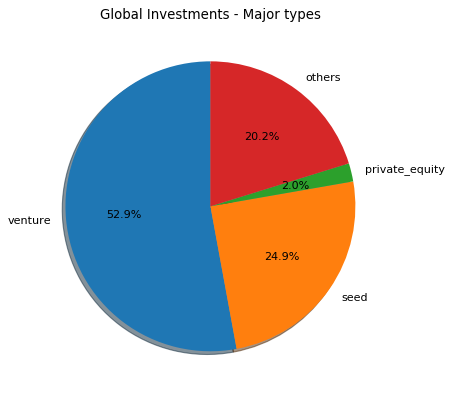

In [46]:
# Create a pie chart
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.pie(fund_types_data['count'],
        labels = fund_types_data.index.values,
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90,
        )

plt.title('Global Investments - Major types')

plt.show()

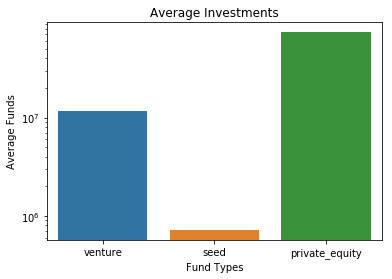

In [47]:
# Creating a barchart for the average investments in Log Scale since the values are too high

fund_types_data = fund_types_data[0:3]
ax = sns.barplot(x=fund_types_data.index.values, y=fund_types_data['mean'])
ax.set_title('Average Investments')
ax.set(xlabel='Fund Types', ylabel='Average Funds')
ax.set_yscale('log')

In [48]:
# Plot for top 9 countries against toal amount of investment in venture type funding
# Here language is not taken into conisderation, the values are filtered out in the subsequent graph.

top9_plot_data = top9.groupby('country_code').sum()

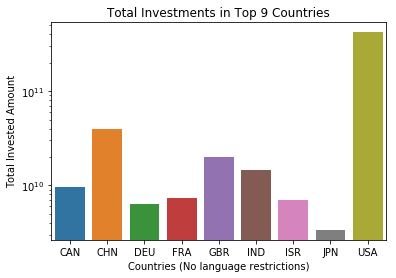

In [49]:
ax = sns.barplot(x=top9_plot_data.index.values, y=top9_plot_data['raised_amount_usd'])
ax.set_title('Total Investments in Top 9 Countries')
ax.set(xlabel='Countries (No language restrictions)', ylabel='Total Invested Amount')
ax.set_yscale('log')

In [50]:
# Getting the data for the top 3 sectors (In terms of number of investments in Venture type) in top 3 english speaking countries.
D3_plot_data = D3.groupby('main_sector').count().sort_values('raised_amount_usd',ascending = False).head(3)['total_number_investment__group']
D2_plot_data = D2.groupby('main_sector').count().sort_values('raised_amount_usd',ascending = False).head(3)['total_number_investment__group']
D1_plot_data = D1.groupby('main_sector').count().sort_values('raised_amount_usd',ascending = False).head(3)['total_number_investment__group']

In [51]:
D1_plot_data

main_sector
Others                                     2950
Social, Finance, Analytics, Advertising    2714
Cleantech / Semiconductors                 2300
Name: total_number_investment__group, dtype: int64

In [52]:
D2_plot_data

main_sector
Others                                     147
Social, Finance, Analytics, Advertising    133
Cleantech / Semiconductors                 128
Name: total_number_investment__group, dtype: int64

In [53]:
D3_plot_data

main_sector
Others                                     110
Social, Finance, Analytics, Advertising     60
News, Search and Messaging                  52
Name: total_number_investment__group, dtype: int64

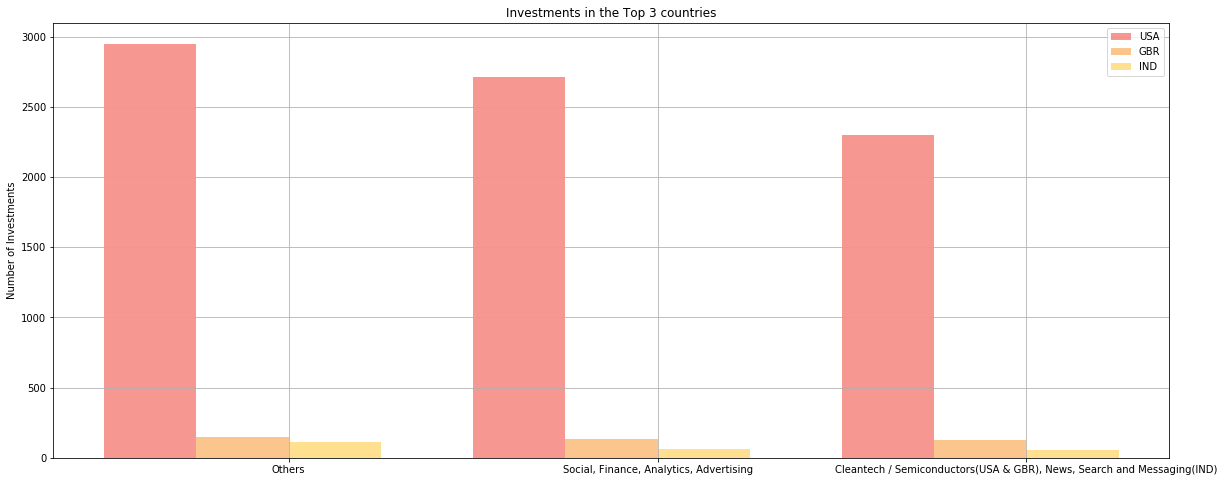

In [54]:
# Plotting data for the above. X axis has the Groups of Top 1, 2 and 3 Sectors which are further grouped into countries
# Y axis shows the Number of investments in each of those sectors.

width = 0.25 

fig, ax = plt.subplots(figsize=(20,8))

plt.bar([0,1,2], 
        D1_plot_data, 
        width, 
        alpha=0.5, 
        color='#EE3224', 
        label='USA') 

plt.bar([p + width for p in range(0,3)], 
        D2_plot_data,
        width, 
        alpha=0.5, 
        color='#F78F1E', 
        label='GBR')

plt.bar([p + width*2 for p in range(0,3)], 
        D3_plot_data, 
        width, 
        alpha=0.5, 
        color='#FFC222', 
        label='IND') 

# Set the y axis label
ax.set_ylabel('Number of Investments')

# Set the chart's title
ax.set_title('Investments in the Top 3 countries')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in range(0,3)])

# Set the labels for the x ticks
ax.set_xticklabels(['Others','Social, Finance, Analytics, Advertising', 'Cleantech / Semiconductors(USA & GBR), News, Search and Messaging(IND)'])

# Adding the legend and showing the plot
plt.legend(['USA', 'GBR', 'IND'], loc='upper right')
plt.grid()
plt.show()

